# Occlusion Experiment: Object Localisation and Image Segmentation using pretrained VGG model

#### Importing Required Libraries

In [1]:
#IMPORTS
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import cv2
import requests
from PIL import Image
import torch.nn as nn

#Using VGG-19 pretrained model for image classification

model = torchvision.models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

/home/priyansh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/priyansh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Loading the Class names

In [2]:
#reading the labels of data we uploaded
with open("imagenet_labels.txt") as f:
    classes = eval(f.read())

#### Defining functions to convert( and reconvert) input image into image suitable for VGG model

In [3]:

# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

def change_image(image):
    new_img = preprocess(image).detach().numpy()
    new_img= new_img.transpose(0,2,3,1).reshape(224,224,3)
    return new_img

#### SALIENCY FUNCTION:
Calculates the 'scores' of each image on every given class and then assigns Class Probability to that image using Softmax Loss. It then takes out the maximum score and pass it backwards on the model to figure out which pixel creates maximum change in the score value.

In [4]:
def saliency_map(img):
    # preprocess the image
    X = preprocess(img)
    
    # h = np.array(img).shape[0]
    # w  = np.array(img).shape[1]
    # we would run the model in evaluation mode
    model.eval()

    # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
    X.requires_grad_()

    scores = model(X)
    
    
    
    # Extra Added Lines
    outputs = nn.functional.softmax(scores, dim = 1)
    #getting the maximum predicted label
    prob_no_occ, pred = torch.max(outputs.data, 1)

    index = torch.argmax(outputs.data,1)
    #get the first item
    prob_no_occ = prob_no_occ[0].item()

    print(f"Class is {classes[index.numpy()[0]]} and confidence is {prob_no_occ}")

    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]

    score_max.backward()

    saliency, _ = torch.max(X.grad.data.abs(),dim=1)
    saliency = saliency.detach().numpy()
    saliency = saliency.transpose(1,2,0)
    saliency = saliency.reshape(224,224)
    return saliency



#### Function to effectively plot the Input Image, Transformed(VGG model ready) Image and the created HeatMap/ Saliency Map.

In [24]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

index=0

def plot_img(image, new_img, saliency):
    global index
    fig = plt.figure(figsize=(12, 12))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
    index+=1
    
    # Original image
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(image)
    ax0.set_title("Original Image")

    # Image after some transformation
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.imshow(new_img)
    ax1.set_title("Transformed Image")

    # Saliency map
    ax2 = fig.add_subplot(gs[1, :])
    ax2.imshow(saliency, cmap=plt.cm.hot)
    ax2.set_title("Saliency Map")

    plt.tight_layout()  # Adjust layout to make room for the titles
    plt.savefig(f"heatmaps/combined_image{index}.png")
    plt.show()

#### One final function to aggregate all other functions

In [18]:
def final(image_path):
    image = Image.open(image_path)
    saliency = saliency_map(image)
    new_img = change_image(image)
    plot_img(image,new_img,saliency)

#### Testing the function on sample image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class is mousetrap and confidence is 0.5958044528961182


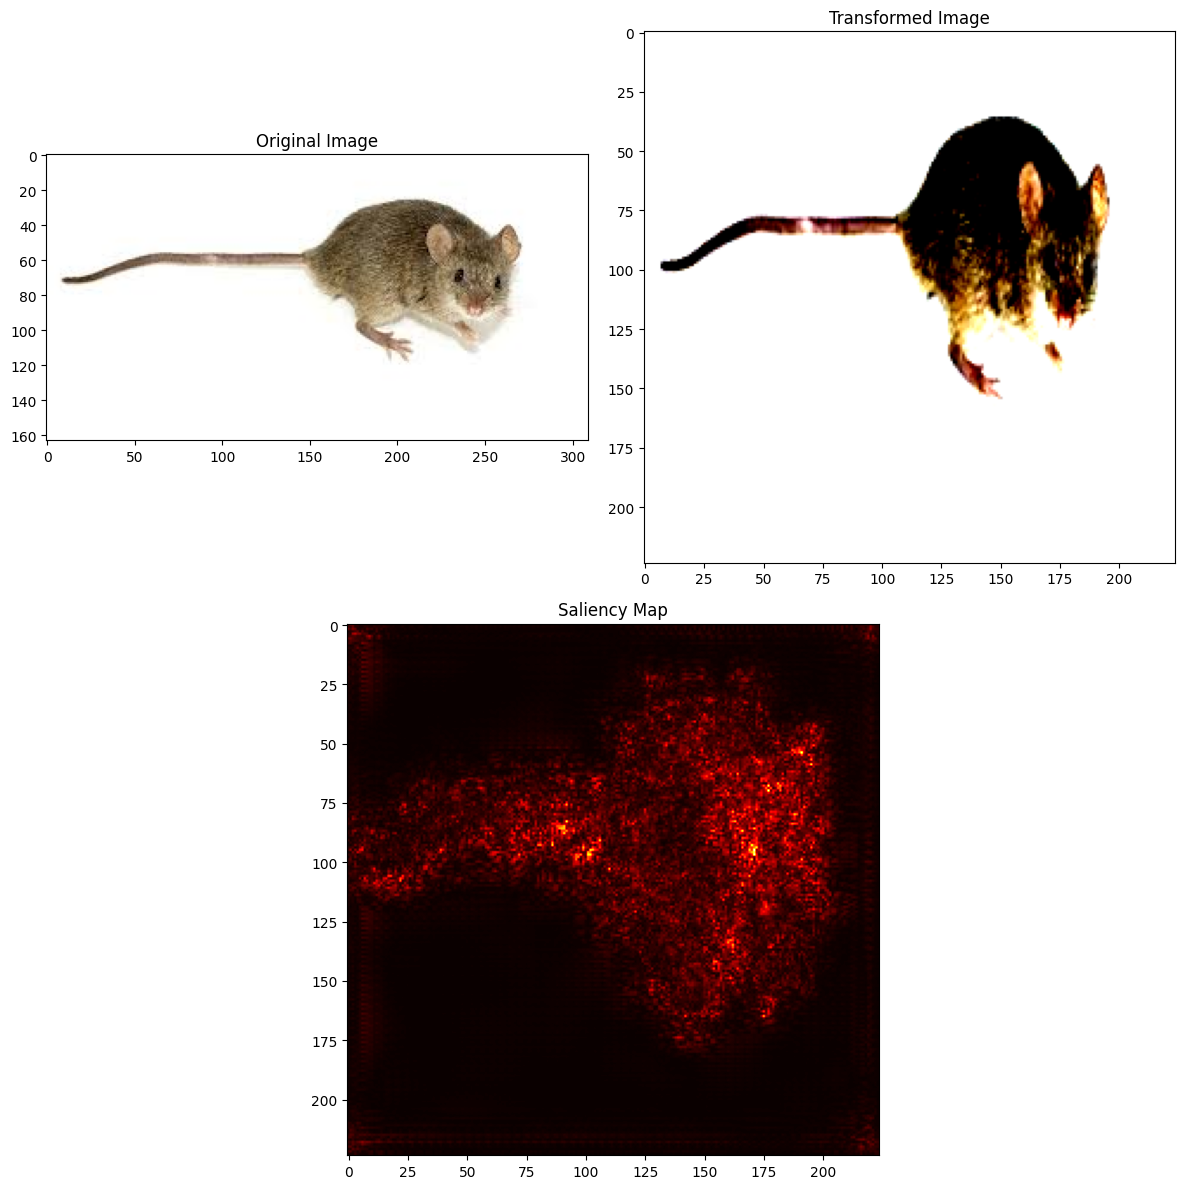

In [28]:
final("images/i13.jpeg")

### ADDING EXTRA FEATURE:
Create a box around the Pixels that create maximum activations in the final layer.

In [8]:
import cv2
import numpy as np

# Assuming 'heatmap' is defined elsewhere and is the input image
def box(heatmap):
    gray = heatmap
    gray = cv2.convertScaleAbs(gray, alpha=(255.0))
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Find contours
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Find the largest contour based on area
    largest_contour = max(cnts, key=cv2.contourArea)

    # Assuming 'image' should be a color version of 'gray' for visualization
    # Create a color image from 'gray' for drawing
    image = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    # Draw only the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    return (x,y,w,h)

In [9]:
def create_box(image, saliency):
    
    # Correctly assign dimensions
    height, width = np.array(image).shape[:2]  # Assuming image is a NumPy array
    channels = 3  # Assuming RGB image

    # Coordinates and dimensions of the box
    x, y, w, h = box(saliency)  # Ensure this function is defined and returns correct values

    # Calculate scale factors
    scale_x = width / 224
    scale_y = height / 224

    # Apply scale factors to coordinates and dimensions
    x = int(x * scale_x)
    y = int(y * scale_y)
    w = int(w * scale_x)
    h = int(h * scale_y)
    
    
    x1, y1 = x,y  # Top-left corner
    x2, y2 = x+w, y+h  # Bottom-right corner
    
    

    # Create a mask of zeros with the same shape as the image
    mask = np.zeros((height, width, channels), dtype=np.uint8)

    # Set the values inside the box to 255 (white) for visualization
    mask[y1:y2, x1:x2, :] = 1

    # Create a highlighted image: original image with a semi-transparent box
                # result_image = cv2.addWeighted(image, 1, mask, 0.3, 0)  # Adjust the 0.3 for more/less transparency

    result_image = image * mask  # Uncomment and use when you have an image array
    result_image = cv2.resize(result_image, (width,height))
    return result_image

In [29]:
index = 0
def plot_img(image,new_img,saliency,result):
    global index
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    index+=1
    # Original image
    ax[0][0].imshow(image)
    ax[0][0].set_title("Original Image")
    
    # Image after some transformation
    ax[0, 1].imshow(new_img)
    ax[0, 1].set_title("Transformed Image")
    
    # Saliency map
    ax[1, 0].imshow(saliency, cmap=plt.cm.hot)
    ax[1, 0].set_title("Saliency Map")
    
    # Resulting image with box
    ax[1, 1].imshow(result)
    ax[1, 1].set_title("Object Detected Region")
    plt.savefig(f"heatmaps/boxed_combined_image{index}.png")
    plt.tight_layout()  # Adjust layout to make room for the titles

In [30]:
def final(image_path):
    image = Image.open(image_path)
    saliency = saliency_map(image)
    new_img = change_image(image)
    result = create_box(image,saliency)
    plot_img(image,new_img,saliency,result)
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class is mousetrap and confidence is 0.5958044528961182


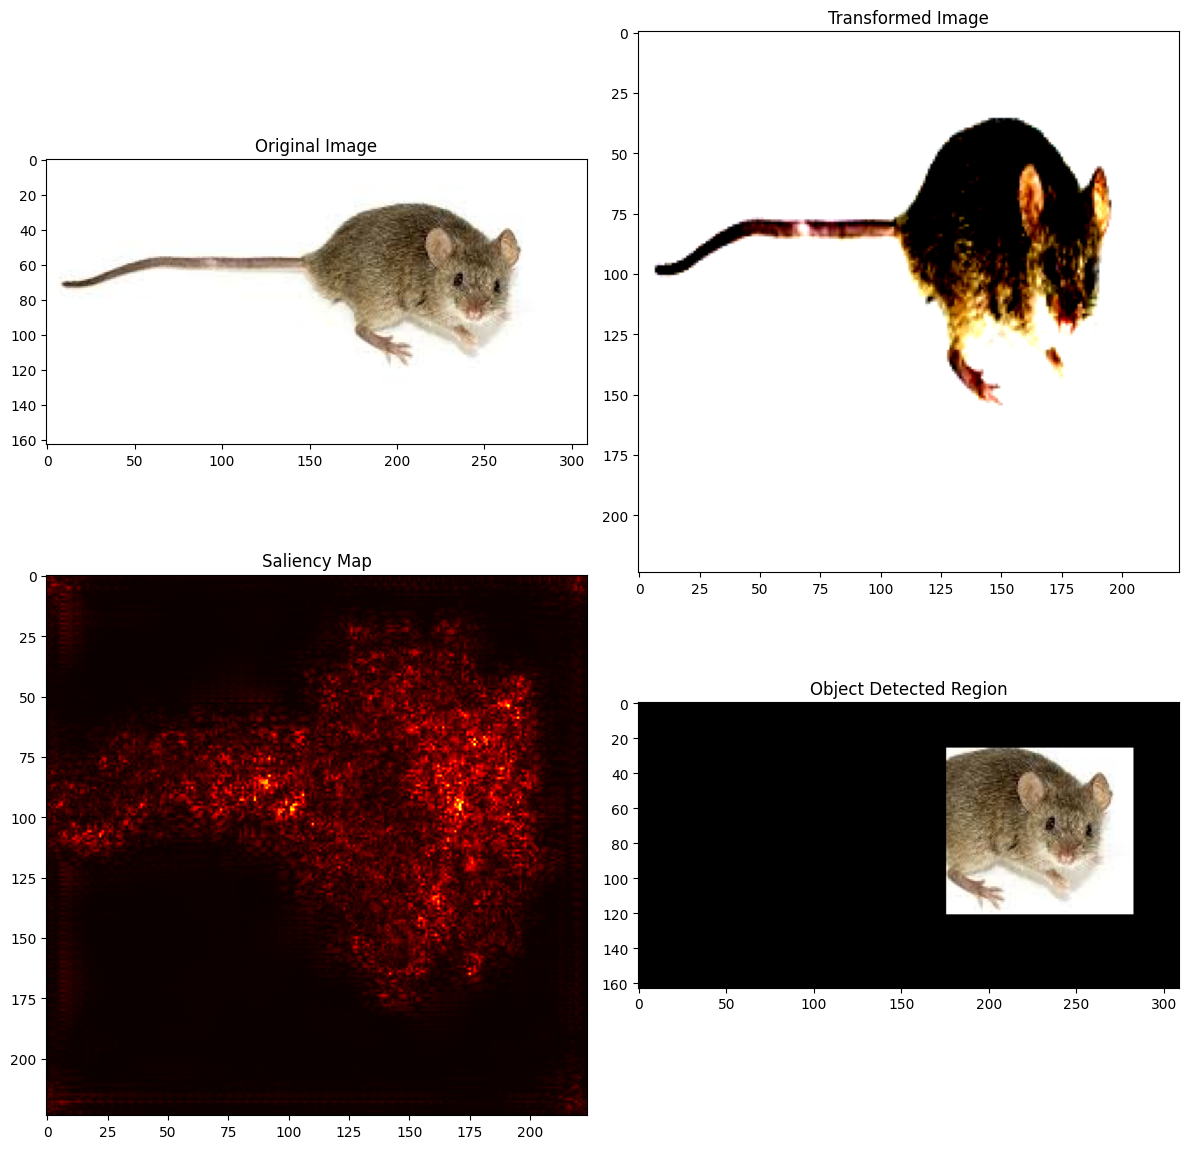

In [33]:
final("images/i13.jpeg")